<a href="https://colab.research.google.com/github/jaramillooo/Tarea5_AECabrera/blob/main/Tarea5_AECabrera.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img style="float: left; margin: 30px 15px 15px 15px;" src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTFzQj91sOlkeDFkg5HDbjtR4QJYmLXkfMNig&usqp=CAU" width="400" height="500" />
    
    
### <font color='navy'> Modelos no lineales para pronósticos.

**Nombres:** Axel Jaramillo, Ricardo Damián Hernández Ramírez

**Fecha:** 12 marzo 2024

**Expediente** : 730793,740356
    
**Profesor:** Oscar David Jaramillo Zuluaga.
    
**Link Github**: [github](https://github.com/jaramillooo/Tarea5_AECabrera)

# Tarea 5: Clase 13

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Descripción de la tarea
# <font color= red>  Tarea  </font>

Implementar todas las técnicas vistas en esta clase al siguiente dataset para predecir el precio de las viviendas:

https://www.kaggle.com/datasets/yasserh/housing-prices-dataset

Código de solución estudiante 1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
import keras
from keras.layers import Conv1D, Flatten, Dense, MaxPooling1D, Input
from keras.models import Sequential
from keras.models import Model
from keras.layers import concatenate
from keras.utils import plot_model


In [2]:
# Código de solución estudiante 1
data = pd.read_csv("/content/drive/MyDrive/series_no_lineales/Housing.csv")
data = pd.get_dummies(data, columns=["mainroad", "guestroom","basement", "hotwaterheating", "airconditioning", "prefarea", "furnishingstatus"], drop_first=True)
data.head

<bound method NDFrame.head of         price  area  bedrooms  bathrooms  stories  parking  mainroad_yes  \
0    13300000  7420         4          2        3        2             1   
1    12250000  8960         4          4        4        3             1   
2    12250000  9960         3          2        2        2             1   
3    12215000  7500         4          2        2        3             1   
4    11410000  7420         4          1        2        2             1   
..        ...   ...       ...        ...      ...      ...           ...   
540   1820000  3000         2          1        1        2             1   
541   1767150  2400         3          1        1        0             0   
542   1750000  3620         2          1        1        0             1   
543   1750000  2910         3          1        1        0             0   
544   1750000  3850         3          1        2        0             1   

     guestroom_yes  basement_yes  hotwaterheating_yes  airconditioning_yes  \
0                0             0                    0                    1   
1                0             0                    0                    1   
2                0             1                    0                    0   
3                0             1                    0                    1   
4                1             1                    0                    1   
..             ...           ...                  ...                  ...   
540              0             1                    0                    0   
541              0             0                    0                    0   
542              0             0                    0                    0   
543              0             0                    0                    0   
544              0             0                    0                    0   

     prefarea_yes  furnishingstatus_semi-furnished  \
0               1                                0   
1               0                                0   
2               1                                1   
3               1                                0   
4               0                                0   
..            ...                              ...   
540             0                                0   
541             0                                1   
542             0                                0   
543             0                                0   
544             0                                0   

     furnishingstatus_unfurnished  
0                               0  
1                               0  
2                               0  
3                               0  
4                               0  
..                            ...  
540                             1  
541                             0  
542                             1  
543                             0  
544                             1  

[545 rows x 14 columns]>

In [3]:
def split_univariate_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # encontrar el final de este patrón
        end_ix = i + n_steps

        # comprobar si estamos más allá de la secuencia
        if end_ix > len(sequence)-1:
            break
        # reunir partes de entrada y salida del patrón
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [4]:
n_steps = 3
X, y = split_univariate_sequence(data["price"], n_steps)
# Número de características de mis datos
n_features = 1

## Modelado con CNN

In [5]:
model_1 = Sequential()
model_1.add(Conv1D(64, 2, activation='relu', input_shape=(n_steps, n_features)))
model_1.add(MaxPooling1D())
model_1.add(Flatten())
model_1.add(Dense(50, activation='relu'))
model_1.add(Dense(1))
model_1.compile(optimizer='adam', loss='mse')
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2, 64)             192       
                                                                 
 max_pooling1d (MaxPooling1  (None, 1, 64)             0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 50)                3250      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 3493 (13.64 KB)
Trainable params: 3493 (13.64 KB)
Non-trainable params: 0 (0.00 Byte)
______________________

In [6]:
n_features = 1

In [7]:
X = X.reshape((X.shape[0], X.shape[1], n_features))
history_1 = model_1.fit(X, y, epochs=1000, verbose=False)

<Axes: >

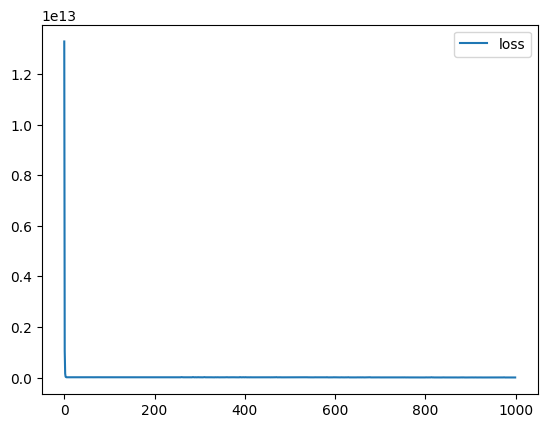

In [8]:
pd.DataFrame(history_1.history).plot()

In [9]:
# Probamos nuestro modelo
x_input = np.array(data['price'][-3:])
x_input = np.reshape(x_input, (1, x_input.shape[0], 1))
yhat = model_1.predict(x_input, verbose=0)
yhat

array([[1723351.8]], dtype=float32)

## Modelos CNN multivariados

In [10]:
def split_multivariate_sequence(sequence: np.ndarray, n_steps: int):
    X, y = list(), list()
    for i in range(len(sequence)):
        # encontrar el final de este patrón
        end_ix = i + n_steps

        # comprobar si estamos más allá de la secuencia
        if end_ix > len(sequence):
            break
        # reunir partes de entrada y salida del patrón
        seq_x, seq_y = sequence[i:end_ix, :-1], sequence[end_ix - 1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_steps = 3
X, y = split_multivariate_sequence(data.to_numpy(), n_steps)

n_features = X.shape[2]

X.shape, y.shape

((543, 3, 13), (543,))

In [11]:
model_2 = Sequential()
model_2.add(Conv1D(64, 2, activation='relu', input_shape=(n_steps, n_features)))
model_2.add(MaxPooling1D())
model_2.add(Flatten())
model_2.add(Dense(50, activation='relu'))
model_2.add(Dense(1))
model_2.compile(optimizer='adam', loss='mse')
model_2.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 2, 64)             1728      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 1, 64)             0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 50)                3250      
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 5029 (19.64 KB)
Trainable params: 5029 (19.64 KB)
Non-trainable params: 0 (0.00 Byte)
____________________

<Axes: >

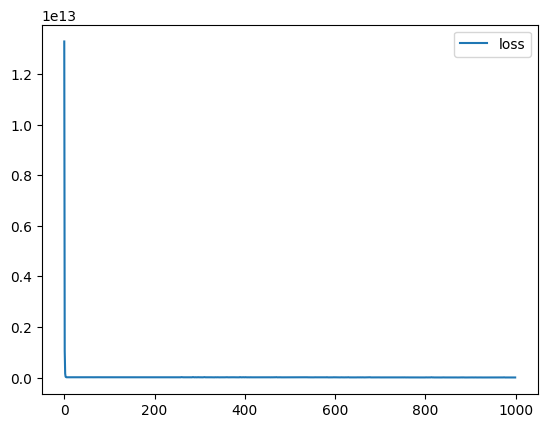

In [12]:
history_2 = model_2.fit(X, y, epochs=1000, verbose=False)
pd.DataFrame(history_1.history).plot()

In [13]:
x_input = X[-10:][0]
x_input = x_input.reshape((1, 3, n_features))
yhat = model_2.predict(x_input, verbose=0)
yhat

array([[92.83569]], dtype=float32)

## Modelo CNN con múltiples encabezamientos

In [14]:
!pip install keras

In [18]:
# Primer modelo de entrada
n_features = 1
n_steps = 3


visible1 = Input(shape=(n_steps, n_features))
cnn1 = Conv1D(64, 2, activation='relu')(visible1)
cnn1 = MaxPooling1D()(cnn1)
cnn1 = Flatten()(cnn1)

In [19]:
# Segundo modelo de entrada
visible2 = Input(shape=(n_steps, n_features))
cnn2 = Conv1D(64, 2, activation='relu')(visible2)
cnn2 = MaxPooling1D()(cnn2)
cnn2 = Flatten()(cnn2)

In [20]:
# merge modelos de entrada
merge = concatenate([cnn1, cnn2])
dense = Dense(50, activation='relu')(merge)
output = Dense(1)(dense)

In [21]:
# Conectar entradas y salida del modelo
model_3 = Model(inputs=[visible1, visible2], outputs=output)

model_3.compile(optimizer='adam', loss='mse')

model_3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 3, 1)]               0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 3, 1)]               0         []                            
                                                                                                  
 conv1d_4 (Conv1D)           (None, 2, 64)                192       ['input_3[0][0]']             
                                                                                                  
 conv1d_5 (Conv1D)           (None, 2, 64)                192       ['input_4[0][0]']             
                                                                                              

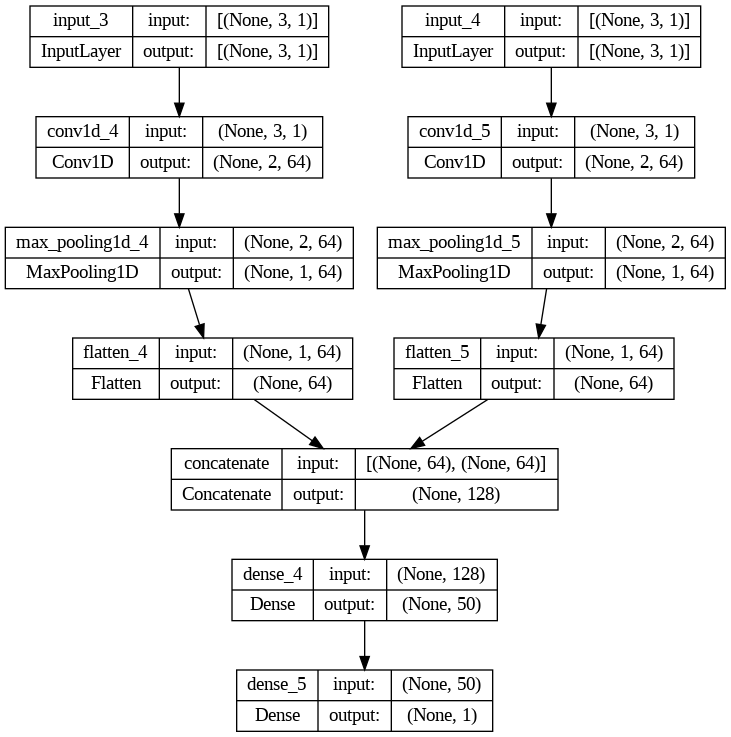

In [22]:
plot_model(model_3, to_file='model.png', show_shapes=True, show_layer_names=True)

In [23]:
# Una serie de tiempo por submodelo
n_features = 1

# Separar datos de entrada
X1 = X[:, :, 0].reshape(X.shape[0], X.shape[1], n_features)
X2 = X[:, :, 1].reshape(X.shape[0], X.shape[1], n_features)

<Axes: >

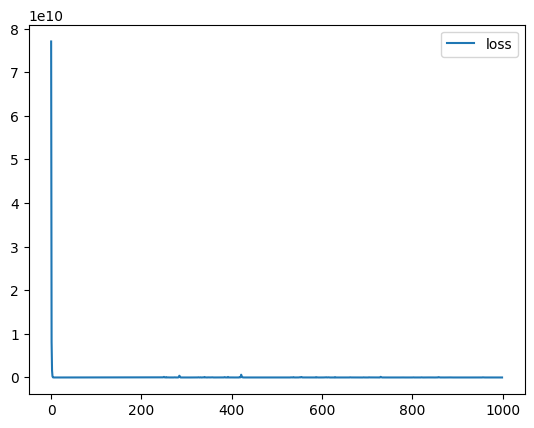

In [24]:
history_3 = model_3.fit([X1, X2], y, epochs=1000, verbose=0)
pd.DataFrame(history_3.history).plot()

In [30]:
x_input1 = X1[-3:][0].reshape((1, n_steps, n_features))
x_input2 = X2[-3:][0].reshape((1, n_steps, n_features))
yhat = model_3.predict([x_input1, x_input2], verbose=0)
yhat

array([[335.67365]], dtype=float32)

## Múltiples series paralelas (multivariable forecasting)

In [32]:
# dividir una secuencia multivariada en muestras para predicción múltiple
def split_multiple_forecasting_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # encontrar el final de este patrón
        end_ix = i + n_steps

        # comprobar si estamos más allá de la secuencia
        if end_ix > len(sequence)-1:
            break
        # reunir partes de entrada y salida del patrón
        seq_x, seq_y = sequence[i:end_ix, :], sequence[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [34]:
n_steps = 3
X_m, y_m = split_multiple_forecasting_sequence(data.to_numpy(), n_steps=3)

In [42]:
X_m.shape

(542, 3, 14)

In [38]:
n_features = X_m.shape[2]

# define model_4
model_4 = Sequential()
model_4.add(Conv1D(64, 2, activation='relu', input_shape=(n_steps, n_features)))
model_4.add(MaxPooling1D())
model_4.add(Flatten())
model_4.add(Dense(50, activation='relu'))
model_4.add(Dense(n_features))
model_4.compile(optimizer='adam', loss='mse')

model_4.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 2, 64)             1856      
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 1, 64)             0         
 g1D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 50)                3250      
                                                                 
 dense_7 (Dense)             (None, 14)                714       
                                                                 
Total params: 5820 (22.73 KB)
Trainable params: 5820 (22.73 KB)
Non-trainable params: 0 (0.00 Byte)
____________________

In [39]:
history_4 = model_4.fit(X_m, y_m, epochs=1000, verbose=0)

<Axes: >

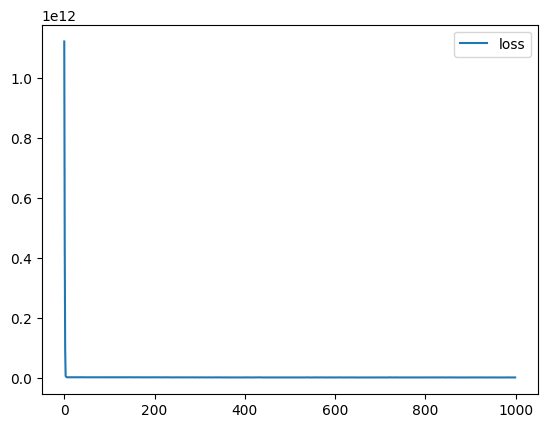

In [40]:
pd.DataFrame(history_4.history).plot()

In [52]:
x_input = X_m[-100].reshape((1, n_steps, n_features))
yhat = model_4.predict(x_input, verbose=0)
yhat

array([[ 3.1718538e+06, -1.3689834e+03, -3.9152151e+02,  8.8800043e+02,
         1.2695592e+03,  8.8091789e+01,  3.0729146e+03,  9.9161145e+02,
        -2.2241599e+02, -1.2446910e+02,  3.4426459e+02,  1.1927401e+03,
         5.2106744e+02,  5.4518652e+03]], dtype=float32)

## Multi-output CNN Model


In [73]:
n_features = X_m.shape[2]

visible = Input(shape=(n_steps, n_features))
cnn = Conv1D(64, 2, activation='relu')(visible)
cnn = MaxPooling1D()(cnn)
cnn = Flatten()(cnn)
cnn = Dense(50, activation='relu')(cnn)

In [74]:
# Definimos salida 1
output1 = Dense(1)(cnn)
# Definimos salida 2
output2 = Dense(1)(cnn)
# Definimos salida 3
output3 = Dense(1)(cnn)

In [75]:
# Ponemos todo junto
model_5 = Model(inputs=visible, outputs=[output1, output2, output3])
model_5.compile(optimizer='adam', loss='mse')

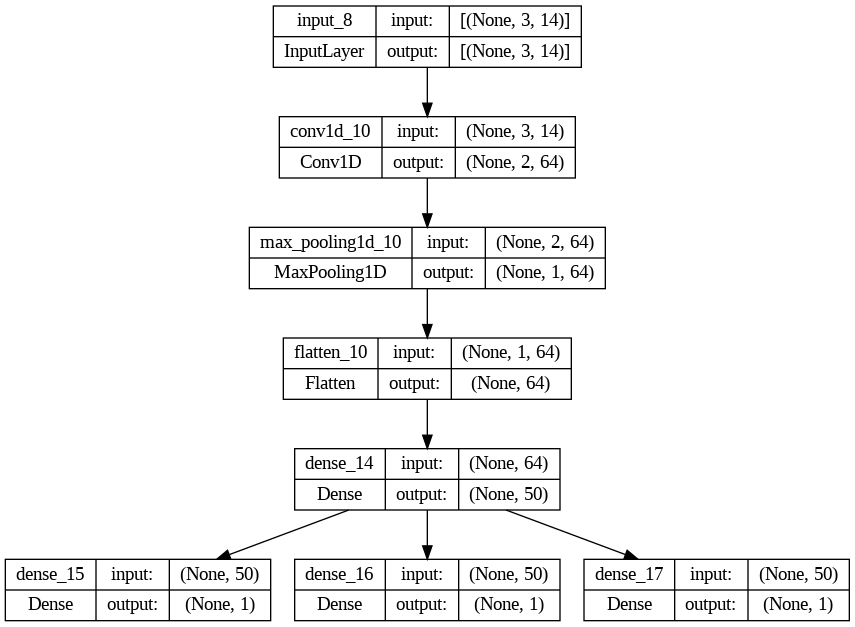

In [77]:
plot_model(model_5, show_shapes=True, show_layer_names=True)

In [78]:
model_5.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 3, 14)]              0         []                            
                                                                                                  
 conv1d_10 (Conv1D)          (None, 2, 64)                1856      ['input_8[0][0]']             
                                                                                                  
 max_pooling1d_10 (MaxPooli  (None, 1, 64)                0         ['conv1d_10[0][0]']           
 ng1D)                                                                                            
                                                                                                  
 flatten_10 (Flatten)        (None, 64)                   0         ['max_pooling1d_10[0][0]

In [62]:
y_m.shape

(542, 14)

In [80]:
# Separar salidas
y1 = y_m[:, 0].reshape((y_m.shape[0], 1))
y2 = y_m[:, 1].reshape((y_m.shape[0], 1))
y3 = y_m[:, 2].reshape((y_m.shape[0], 1))

y_list = [y1, y2, y3]

In [83]:
history_5 = model_5.fit(X_m, y_list, epochs=700, verbose=0)

<Axes: >

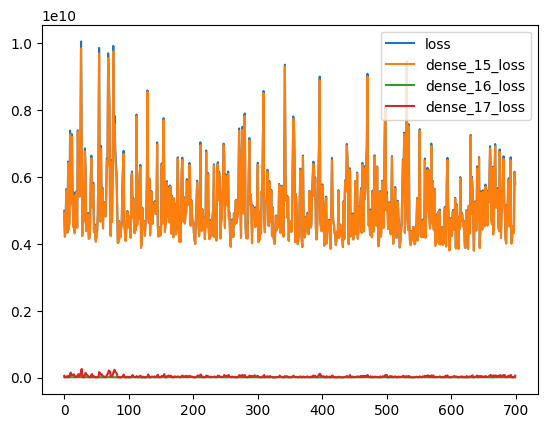

In [84]:
pd.DataFrame(history_5.history).plot()

# Modelos CNN de pasos múltiples

## Serie temporal univariada

In [86]:
# dividir una secuencia univariada en muestras
def split_univariate_sequence_m_step(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # encontrar el final de este patrón
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out

        # comprobar si estamos más allá de la secuencia
        if out_end_ix > len(sequence):
            break
        # reunir partes de entrada y salida del patrón
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [88]:
raw_seq = data["price"]
n_steps_in, n_steps_out = 3, 2
# Particionar mis datos
X, y = split_univariate_sequence_m_step(raw_seq, n_steps_in, n_steps_out)
# Resumir los datos
X.shape, y.shape

((541, 3), (541, 2))

In [89]:
# Debemos tranformar nuestro datos de [samples, timesteps] a [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
X.shape

(541, 3, 1)

In [90]:
# Crear nuestro modelo
model_6 = Sequential()
model_6.add(Conv1D(64, 2, activation='relu', input_shape=(n_steps_in, n_features)))
model_6.add(MaxPooling1D())
model_6.add(Flatten())
model_6.add(Dense(50, activation='relu'))
model_6.add(Dense(n_steps_out))
model_6.compile(optimizer='adam', loss='mse')

model_6.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_11 (Conv1D)          (None, 2, 64)             192       
                                                                 
 max_pooling1d_11 (MaxPooli  (None, 1, 64)             0         
 ng1D)                                                           
                                                                 
 flatten_11 (Flatten)        (None, 64)                0         
                                                                 
 dense_18 (Dense)            (None, 50)                3250      
                                                                 
 dense_19 (Dense)            (None, 2)                 102       
                                                                 
Total params: 3544 (13.84 KB)
Trainable params: 3544 (13.84 KB)
Non-trainable params: 0 (0.00 Byte)
____________________

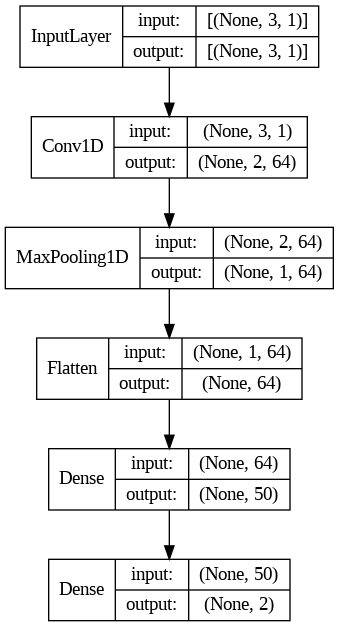

In [91]:
plot_model(model_6, show_layer_names=False, show_shapes=True,)

In [92]:
history_6 = model_6.fit(X, y, epochs=1000, verbose=0)

<Axes: >

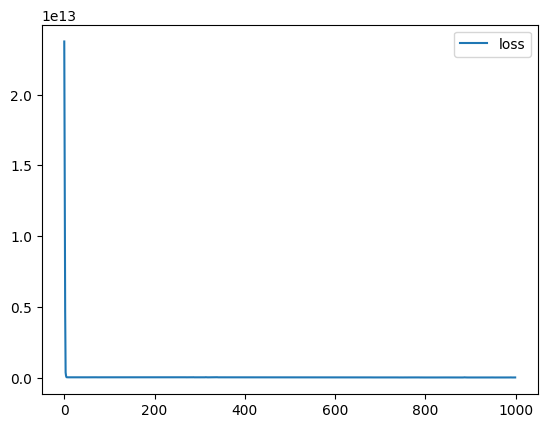

In [93]:
pd.DataFrame(history_6.history).plot()

In [94]:
x_input = X[-5].reshape((1, n_steps_in, n_features))
yhat = model_6.predict(x_input, verbose=0)
print('Predicción', yhat)

Predicción [[1856246.  1814483.4]]


## Serie temporal multivariada

In [96]:
# dividir una secuencia multivariada en muestras
def split_multivariate_sequence_m_step(sequence: np.ndarray, n_steps_in: int, n_steps_out: int):
    X, y = list(), list()
    for i in range(len(sequence)):
        # encontrar el final de este patrón
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1

        # comprobar si estamos más allá de la secuencia
        if out_end_ix > len(sequence):
            break
        # reunir partes de entrada y salida del patrón
        seq_x, seq_y = sequence[i:end_ix, :-1], sequence[end_ix-1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [99]:
# Elegir un número de pasos de tiempo
n_steps_in, n_steps_out = 3, 2

X, y = split_multivariate_sequence_m_step(data.to_numpy(), n_steps_in, n_steps_out)
X.shape, y.shape

((542, 3, 13), (542, 2))

In [100]:
n_features = X.shape[2]

# Definir el modelo
model_7 = Sequential()
model_7.add(Conv1D(64, 2, activation='relu', input_shape=(n_steps_in, n_features)))
model_7.add(MaxPooling1D())
model_7.add(Flatten())
model_7.add(Dense(50, activation='relu'))
model_7.add(Dense(n_steps_out))
model_7.compile(optimizer='adam', loss='mse')
# fit model_7
model_7.fit(X, y, epochs=2000, verbose=0)

model_7.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 2, 64)             1728      
                                                                 
 max_pooling1d_12 (MaxPooli  (None, 1, 64)             0         
 ng1D)                                                           
                                                                 
 flatten_12 (Flatten)        (None, 64)                0         
                                                                 
 dense_20 (Dense)            (None, 50)                3250      
                                                                 
 dense_21 (Dense)            (None, 2)                 102       
                                                                 
Total params: 5080 (19.84 KB)
Trainable params: 5080 (19.84 KB)
Non-trainable params: 0 (0.00 Byte)
____________________

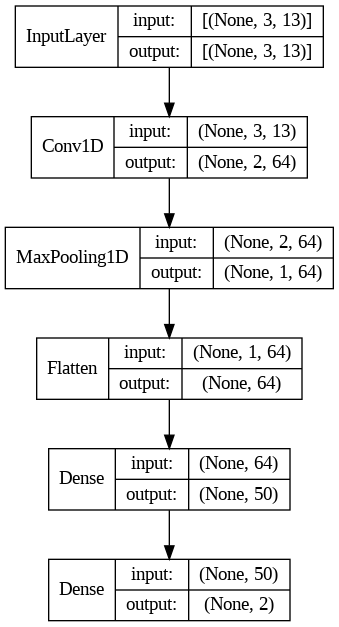

In [101]:
plot_model(model_7, show_layer_names=False, show_shapes=True,)

In [105]:
x_input = X[-2].reshape((1, n_steps_in, n_features))
yhat = model_7.predict(x_input, verbose=0)
print("predicción:", yhat)

predicción: [[ 144.10635 -235.252  ]]


## Serie temporal multivariada predicción múltiple de cada entrada

In [106]:
# dividir una secuencia multivariada en muestras
def split_multivariate_sequence_m_step_parallel(sequence: np.ndarray, n_steps_in: int, n_steps_out: int):
    X, y = list(), list()
    for i in range(len(sequence)):
        # encontrar el final de este patrón
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out

        # comprobar si estamos más allá de la secuencia
        if out_end_ix > len(sequence):
            break
        # reunir partes de entrada y salida del patrón
        seq_x, seq_y = sequence[i:end_ix, :], sequence[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [108]:
# Elegir un número de pasos de tiempo
n_steps_in, n_steps_out = 3, 2

X, y = split_multivariate_sequence_m_step_parallel(data.to_numpy(), n_steps_in, n_steps_out)
X.shape ,y.shape

((541, 3, 14), (541, 2, 14))

In [109]:
# flatten output
n_output = y.shape[1] * y.shape[2]
y = y.reshape((y.shape[0], n_output))
y.shape

(541, 28)

In [110]:
n_features = X.shape[2]

# Definimos nuestro modelo
model_8 = Sequential()
model_8.add(Conv1D(64, 2, activation='relu', input_shape=(n_steps_in, n_features)))
model_8.add(MaxPooling1D())
model_8.add(Flatten())
model_8.add(Dense(50, activation='relu'))
model_8.add(Dense(n_output))
model_8.compile(optimizer='adam', loss='mse')

# fit model_8
history_8 = model_8.fit(X, y, epochs=1000, verbose=0)

<Axes: >

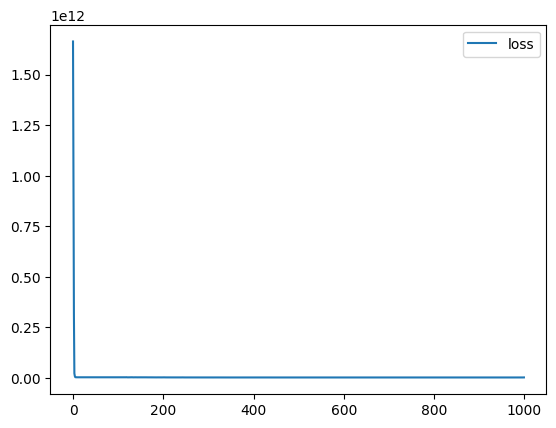

In [111]:
pd.DataFrame(history_8.history).plot()

In [112]:
x_input = X[-5].reshape((1, n_steps_in, n_features))
yhat = model_8.predict(x_input, verbose=0)
print(yhat)

[[ 1.8886854e+06  2.1447883e+03 -6.0858154e+02  2.1878774e+03
  -1.3339860e+03 -4.6113144e+01 -7.4144873e+02 -1.0474415e+02
  -4.4895981e+02  1.1007738e+03  1.5722347e+03  2.8700151e+03
  -4.3455536e+02 -2.1083611e+03  1.8662564e+06  3.2736941e+03
  -1.5530623e+03 -6.7005371e+02  3.9751389e+02  1.2880497e+03
  -3.6593521e+02 -7.4445923e+02  1.2589753e+03  2.0114607e+02
  -2.3620916e+03 -1.6481353e+03  2.9771460e+02 -2.0010016e+03]]


In [113]:
[yhat[i].reshape(n_steps_out, n_features) for i in range(yhat.shape[0])]

[array([[ 1.8886854e+06,  2.1447883e+03, -6.0858154e+02,  2.1878774e+03,
         -1.3339860e+03, -4.6113144e+01, -7.4144873e+02, -1.0474415e+02,
         -4.4895981e+02,  1.1007738e+03,  1.5722347e+03,  2.8700151e+03,
         -4.3455536e+02, -2.1083611e+03],
        [ 1.8662564e+06,  3.2736941e+03, -1.5530623e+03, -6.7005371e+02,
          3.9751389e+02,  1.2880497e+03, -3.6593521e+02, -7.4445923e+02,
          1.2589753e+03,  2.0114607e+02, -2.3620916e+03, -1.6481353e+03,
          2.9771460e+02, -2.0010016e+03]], dtype=float32)]

# Código de solución estudiante 2: Ricardo Damián Hernández Ramírez

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv("Housing.csv")
data.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [ ]:
data.isnull().sum()

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

## 1. Modelo CNN univariado

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv1D, MaxPooling1D

In [ ]:
# dividir una secuencia univariada en muestras
def split_univariate_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # encontrar el final de este patrón
        end_ix = i + n_steps

        # comprobar si estamos más allá de la secuencia
        if end_ix > len(sequence)-1:
            break
        # reunir partes de entrada y salida del patrón
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [ ]:
column = 'price'
n_steps = 3
X, y = split_univariate_sequence(data[column], n_steps)
# Número de características de mis datos
n_features = 1

In [ ]:
model_1 = Sequential()
model_1.add(Conv1D(64, 2, activation='relu', input_shape=(n_steps, n_features)))
model_1.add(MaxPooling1D())
model_1.add(Flatten())
model_1.add(Dense(50, activation='relu'))
model_1.add(Dense(1))
model_1.compile(optimizer='adam', loss='mse')
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2, 64)             192       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 64)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 50)                3250      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 3,493
Trainable params: 3,493
Non-trainable params: 0
______________________________________________________

In [ ]:
X.shape


(542, 3)

In [ ]:
X = X.reshape((X.shape[0], X.shape[1], n_features))
X

array([[[13300000],
        [12250000],
        [12250000]],

       [[12250000],
        [12250000],
        [12215000]],

       [[12250000],
        [12215000],
        [11410000]],

       ...,

       [[ 1855000],
        [ 1820000],
        [ 1767150]],

       [[ 1820000],
        [ 1767150],
        [ 1750000]],

       [[ 1767150],
        [ 1750000],
        [ 1750000]]], dtype=int64)

In [ ]:
history_1 = model_1.fit(X,y, epochs = 1000, verbose = False)

<AxesSubplot:>

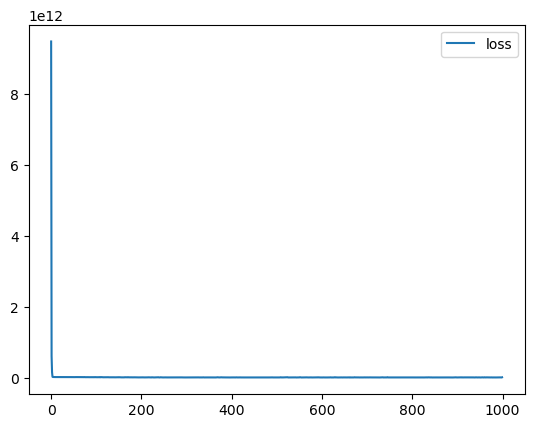

In [ ]:
pd.DataFrame(history_1.history).plot()


In [ ]:
x_input = np.array(data['price'][-3:])

# Luego remodelamos para que coincida con la forma de entrada del modelo
x_input = np.reshape(x_input, (1, x_input.shape[0], 1))

# Finalmente, predecimos utilizando el modelo
yhat = model_1.predict(x_input, verbose=0)
yhat

array([[1737818.5]], dtype=float32)


2. Modelos CNN multivariados

2.1 Series de entradas múltiples

In [ ]:
cat = data.select_dtypes(exclude='int')  # Seleccionar las columnas categóricas
dummy = pd.get_dummies(data[cat.columns], drop_first=True)  # Obtener las variables dummy
dummy = dummy.astype('int')  # Convertir las variables dummy a tipo entero
data_without_cat = data.drop(columns=cat.columns)

# Concatenar data original sin las columnas categóricas y las variables dummy
data_dummy = pd.concat([data_without_cat, dummy], axis=1)
# Mover la columna price a
price_column = data_dummy.pop('price')
data_dummy['price'] = price_column


In [ ]:
# dividir una secuencia multivariada en muestras
def split_multivariate_sequence(sequence: np.ndarray, n_steps: int):
    X, y = list(), list()
    for i in range(len(sequence)):
        # encontrar el final de este patrón
        end_ix = i + n_steps

        # comprobar si estamos más allá de la secuencia
        if end_ix > len(sequence):
            break
        # reunir partes de entrada y salida del patrón
        seq_x, seq_y = sequence[i:end_ix, :-1], sequence[end_ix - 1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [ ]:
n_steps = 3
X, y = split_multivariate_sequence(data_dummy.to_numpy(), n_steps)

n_features = X.shape[2]

X.shape, y.shape

((543, 3, 13), (543,))

In [ ]:
# Definimos nuestro modelo
model_2 = Sequential()
model_2.add(Conv1D(64, 2, activation='relu', input_shape=(n_steps, n_features)))
model_2.add(MaxPooling1D())
model_2.add(Flatten())
model_2.add(Dense(50, activation='relu'))
model_2.add(Dense(1))
model_2.compile(optimizer='adam', loss='mse')
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 2, 64)             1728      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 50)                3250      
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 5,029
Trainable params: 5,029
Non-trainable params: 0
____________________________________________________

In [ ]:
history_2 = model_2.fit(X,y, epochs = 1000, verbose = False)

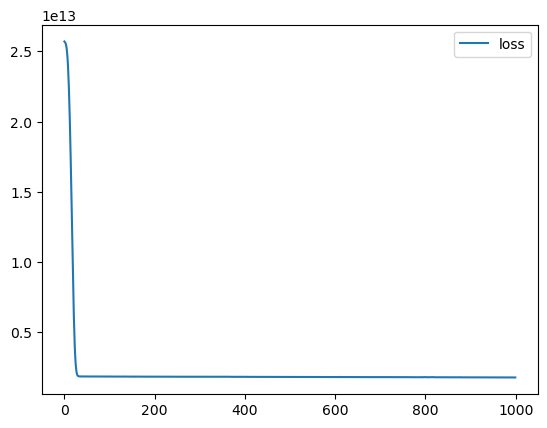

In [ ]:
pd.DataFrame(history_2.history).plot()
plt.show()

In [ ]:
last_three_samples = X[-3:][0]
input_array = last_three_samples
input_array_reshaped = input_array.reshape((1, n_steps, n_features))
predicted_y = model_2.predict(input_array_reshaped, verbose=0)
predicted_y

array([[2512002.8]], dtype=float32)

## Modelo CNN con múltiples encabezamientos

In [ ]:
# Paqueterías faltantes
from keras.models import Model
from keras.layers import concatenate, Input
from keras.utils import plot_model

In [ ]:
n_features = 1
n_steps = 3

In [ ]:
# Primer modelo de entrada
visible1 = Input(shape=(n_steps, n_features))
cnn1 = Conv1D(64, 2, activation='relu')(visible1)
cnn1 = MaxPooling1D()(cnn1)
cnn1 = Flatten()(cnn1)

In [ ]:
# Segundo modelo de entrada
visible2 = Input(shape=(n_steps, n_features))
cnn2 = Conv1D(64, 2, activation='relu')(visible2)
cnn2 = MaxPooling1D()(cnn2)
cnn2 = Flatten()(cnn2)

In [ ]:
# merge modelos de entrada
merge = concatenate([cnn1, cnn2])
dense = Dense(50, activation='relu')(merge)
output = Dense(1)(dense)

In [ ]:
# Conectar entradas y salida del modelo
model_3 = Model(inputs=[visible1, visible2], outputs=output)

model_3.compile(optimizer='adam', loss='mse')

model_3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3, 1)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 3, 1)]       0           []                               
                                                                                                  
 conv1d_2 (Conv1D)              (None, 2, 64)        192         ['input_1[0][0]']                
                                                                                                  
 conv1d_3 (Conv1D)              (None, 2, 64)        192         ['input_2[0][0]']                
                                                                                              

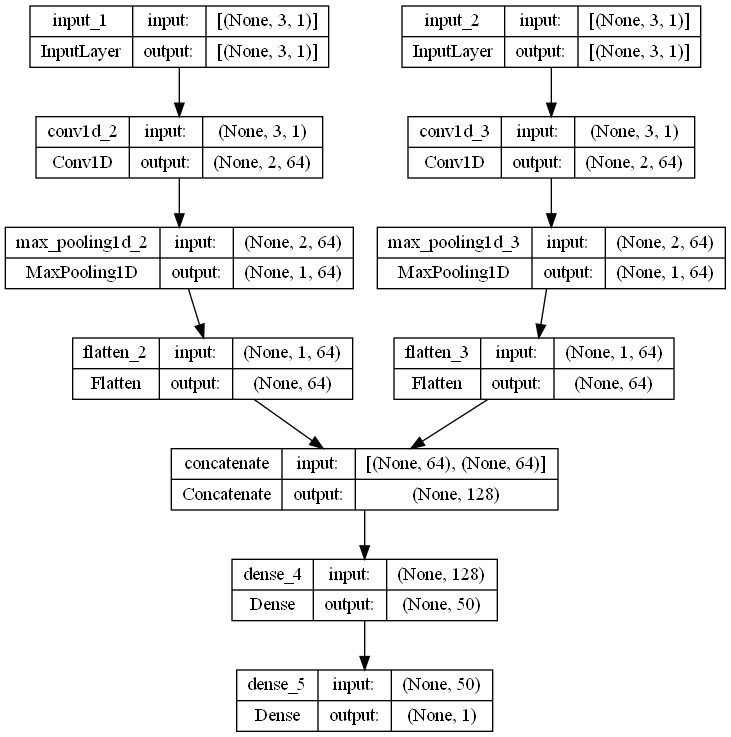

In [ ]:
plot_model(model_3, to_file='model.png', show_shapes=True, show_layer_names=True)


In [ ]:
X[0].shape

(3, 13)

In [ ]:
# Una serie de tiempo por submodelo
n_features = 1

# Separar datos de entrada
X1 = X[:, :, 0].reshape(X.shape[0], X.shape[1], n_features)
X2 = X[:, :, 1].reshape(X.shape[0], X.shape[1], n_features)

In [ ]:
X1.shape


(543, 3, 1)

In [ ]:
history_3 = model_3.fit([X1, X2], y, epochs=1000, verbose=0)

<AxesSubplot:>

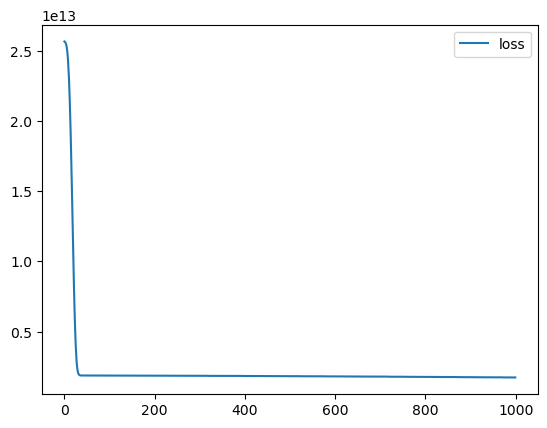

In [ ]:
pd.DataFrame(history_3.history).plot()


In [ ]:
x1 = X1[-3:][0].reshape((1, n_steps, n_features))
x2 = X2[-3:][0].reshape((1, n_steps, n_features))
yhat = model_3.predict([x1, x2], verbose=0)
yhat

array([[2675623.]], dtype=float32)

## 2.2 Múltiples series paralelas (multivariable forecasting)

In [ ]:
# dividir una secuencia multivariada en muestras para predicción múltiple
def split_multiple_forecasting_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # encontrar el final de este patrón
        end_ix = i + n_steps

        # comprobar si estamos más allá de la secuencia
        if end_ix > len(sequence)-1:
            break
        # reunir partes de entrada y salida del patrón
        seq_x, seq_y = sequence[i:end_ix, :], sequence[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [ ]:
n_steps = 3
X_m, y_m = split_multiple_forecasting_sequence(data_dummy.to_numpy(), n_steps=n_steps)


In [ ]:
n_features  = X_m.shape[2]
# define model_4
model_4 = Sequential()
model_4.add(Conv1D(64, 2, activation='relu', input_shape=(n_steps, n_features)))
model_4.add(MaxPooling1D())
model_4.add(Flatten())
model_4.add(Dense(55, activation='relu'))
model_4.add(Dense(n_features))
model_4.compile(optimizer='adam', loss='mse')

model_4.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 2, 64)             1856      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 55)                3575      
                                                                 
 dense_7 (Dense)             (None, 14)                784       
                                                                 
Total params: 6,215
Trainable params: 6,215
Non-trainable params: 0
____________________________________________________

In [ ]:
history_4 = model_4.fit(X_m, y_m, epochs=1000, verbose=0)


<AxesSubplot:>

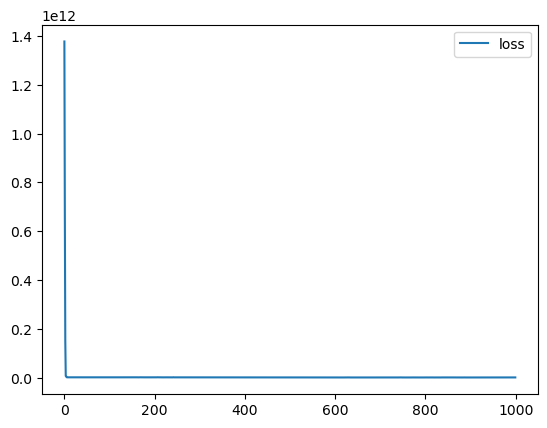

In [ ]:
pd.DataFrame(history_4.history).plot()


In [ ]:
x_input  = X_m[-1].reshape((1, n_steps, n_features))
yhat = model_4.predict(x_input, verbose=0)
print(yhat)


[[ 1.9868502e+03 -1.0895583e+03 -1.1268074e+03  1.9135292e+03
   5.8478308e+02 -3.2797470e+02  5.9982233e+02  9.5722984e+01
  -8.2967419e+02  2.4550841e+02 -8.6280060e+02  1.6659569e+02
   3.7081112e+01  1.7068654e+06]]


## Multi-output CNN Model

In [ ]:
n_features = X_m.shape[2]

visible = Input(shape=(n_steps, n_features))
cnn = Conv1D(64, 2, activation='relu')(visible)
cnn = MaxPooling1D()(cnn)
cnn = Flatten()(cnn)
cnn = Dense(50, activation='relu')(cnn)

In [ ]:
# Definimos salida 1
output1 = Dense(1)(cnn)
# Definimos salida 2
output2 = Dense(1)(cnn)
# Definimos salida 3
output3 = Dense(1)(cnn)

In [ ]:
# Ponemos todo junto
model_5 = Model(inputs=visible, outputs=[output1, output2, output3])
model_5.compile(optimizer='adam', loss='mse')

In [ ]:
model_5.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 3, 14)]      0           []                               
                                                                                                  
 conv1d_5 (Conv1D)              (None, 2, 64)        1856        ['input_3[0][0]']                
                                                                                                  
 max_pooling1d_5 (MaxPooling1D)  (None, 1, 64)       0           ['conv1d_5[0][0]']               
                                                                                                  
 flatten_5 (Flatten)            (None, 64)           0           ['max_pooling1d_5[0][0]']        
                                                                                            

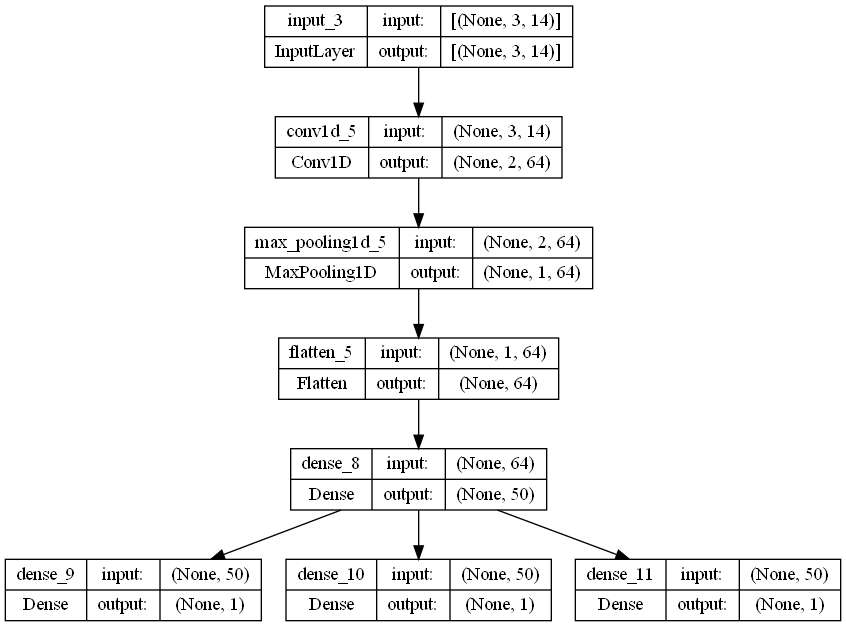

In [ ]:
plot_model(model_5, show_shapes=True, show_layer_names=True)


In [ ]:
y_m.shape

(542, 14)

In [ ]:
# Separar salidas
y1 = y_m[:, 0].reshape((y_m.shape[0], 1))
y2 = y_m[:, 1].reshape((y_m.shape[0], 1))
y3 = y_m[:, 2].reshape((y_m.shape[0], 1))

In [ ]:
y1.shape


(542, 1)

In [ ]:
history_5 = model_5.fit(X_m, [y1,y2,y3], epochs=700, verbose=0)


<AxesSubplot:>

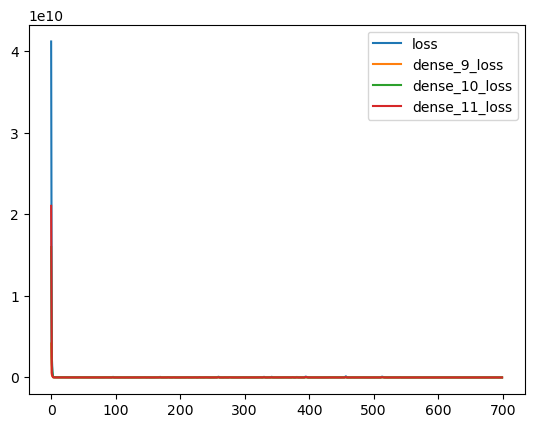

In [ ]:
pd.DataFrame(history_5.history).plot()


## 3. Modelos CNN de pasos múltiples
3.1 Serie temporal univariada

In [ ]:
# dividir una secuencia univariada en muestras
def split_univariate_sequence_m_step(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # encontrar el final de este patrón
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out

        # comprobar si estamos más allá de la secuencia
        if out_end_ix > len(sequence):
            break
        # reunir partes de entrada y salida del patrón
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [ ]:
n_steps_in, n_steps_out  = 3, 2
# Particionar mis datos
X, y = split_univariate_sequence_m_step(data['price'], n_steps_in, n_steps_out)
X.shape, y.shape


((541, 3), (541, 2))

In [ ]:
# Debemos tranformar nuestro datos de [samples, timesteps] a [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
X.shape

(541, 3, 1)

In [ ]:
# Crear nuestro modelo
model_6 = Sequential()
model_6.add(Conv1D(64, 2, activation='relu', input_shape=(n_steps_in, n_features)))
model_6.add(MaxPooling1D())
model_6.add(Flatten())
model_6.add(Dense(50, activation='relu'))
model_6.add(Dense(n_steps_out))
model_6.compile(optimizer='adam', loss='mse')

model_6.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 2, 64)             192       
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 flatten_6 (Flatten)         (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 50)                3250      
                                                                 
 dense_13 (Dense)            (None, 2)                 102       
                                                                 
Total params: 3,544
Trainable params: 3,544
Non-trainable params: 0
____________________________________________________

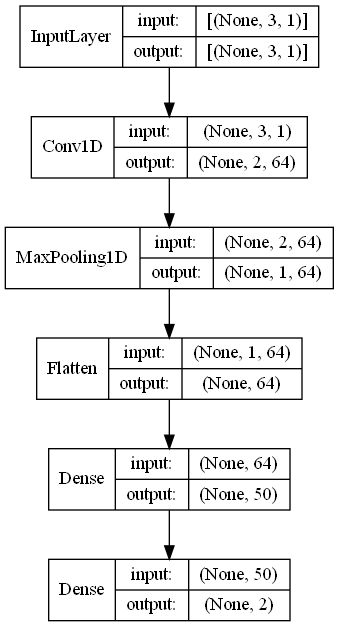

In [ ]:
plot_model(model_6, show_layer_names=False, show_shapes=True,)


In [ ]:
history_6 = model_6.fit(X, y, epochs=1000, verbose=0)


<AxesSubplot:>

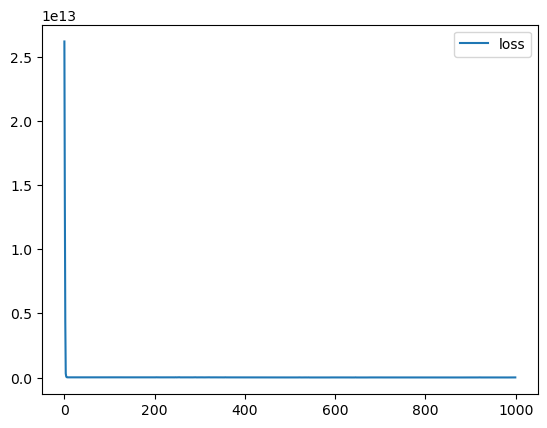

In [ ]:
pd.DataFrame(history_6.history).plot()


In [ ]:
last_sample = X[-1]

# Reshape para que tenga la forma correcta (1, n_steps, n_features)
x_input  = last_sample.reshape((1, n_steps, n_features))

# Hacer la predicción
yhat = model_6.predict(x_input, verbose=0)

# Imprimir las predicciones
print(yhat)

[[1716790.1 1693809.8]]


## 3.2 Serie temporal multivariada

In [ ]:
# dividir una secuencia multivariada en muestras
def split_multivariate_sequence_m_step(sequence: np.ndarray, n_steps_in: int, n_steps_out: int):
    X, y = list(), list()
    for i in range(len(sequence)):
        # encontrar el final de este patrón
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1

        # comprobar si estamos más allá de la secuencia
        if out_end_ix > len(sequence):
            break
        # reunir partes de entrada y salida del patrón
        seq_x, seq_y = sequence[i:end_ix, :-1], sequence[end_ix-1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [ ]:
# Elegir un número de pasos de tiempo
n_steps_in, n_steps_out = 3, 2

X, y = split_multivariate_sequence_m_step(data_dummy.to_numpy(), n_steps_in, n_steps_out)

In [ ]:
n_features = X.shape[2]

# Definir el modelo
model_7 = Sequential()
model_7.add(Conv1D(64, 2, activation='relu', input_shape=(n_steps_in, n_features)))
model_7.add(MaxPooling1D())
model_7.add(Flatten())
model_7.add(Dense(50, activation='relu'))
model_7.add(Dense(n_steps_out))
model_7.compile(optimizer='adam', loss='mse')
# fit model_7
model_7.fit(X, y, epochs=2000, verbose=0)

model_7.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 2, 64)             1728      
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 flatten_7 (Flatten)         (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 50)                3250      
                                                                 
 dense_15 (Dense)            (None, 2)                 102       
                                                                 
Total params: 5,080
Trainable params: 5,080
Non-trainable params: 0
____________________________________________________

In [ ]:
last_sample = X[-1]

# Reshape para que tenga la forma correcta (1, n_steps, n_features)
x_input  = last_sample.reshape((1, n_steps, n_features))

# Hacer la predicción
yhat = model_7.predict(x_input, verbose=0)

# Imprimir las predicciones
print(yhat)

[[2688742. 2676333.]]


## 3.3 Serie temporal multivariada predicción múltiple de cada entrada

In [ ]:
# dividir una secuencia multivariada en muestras
def split_multivariate_sequence_m_step_parallel(sequence: np.ndarray, n_steps_in: int, n_steps_out: int):
    X, y = list(), list()
    for i in range(len(sequence)):
        # encontrar el final de este patrón
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out

        # comprobar si estamos más allá de la secuencia
        if out_end_ix > len(sequence):
            break
        # reunir partes de entrada y salida del patrón
        seq_x, seq_y = sequence[i:end_ix, :], sequence[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [ ]:
# Elegir un número de pasos de tiempo
n_steps_in, n_steps_out = 3, 2

X, y = split_multivariate_sequence_m_step_parallel(data_dummy.to_numpy(), n_steps_in, n_steps_out)
X.shape ,y.shape

((541, 3, 14), (541, 2, 14))

In [ ]:
# flatten output
n_output = y.shape[1] * y.shape[2]
y = y.reshape((y.shape[0], n_output))
y.shape

(541, 28)

In [ ]:
n_features = X.shape[2]

# Definimos nuestro modelo
model_8 = Sequential()
model_8.add(Conv1D(64, 2, activation='relu', input_shape=(n_steps_in, n_features)))
model_8.add(MaxPooling1D())
model_8.add(Flatten())
model_8.add(Dense(50, activation='relu'))
model_8.add(Dense(n_output))
model_8.compile(optimizer='adam', loss='mse')

# fit model_8
history_8 = model_8.fit(X, y, epochs=1000, verbose=0)

<AxesSubplot:>

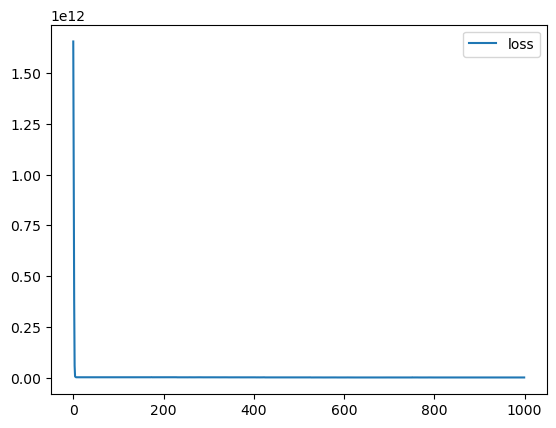

In [ ]:
pd.DataFrame(history_8.history).plot()


In [ ]:
# Probar nuestro model
x_input  = X[-1].reshape((1, n_steps_in, n_features))
yhat  = model_8.predict(x_input, verbose=0)
print(yhat)0


[[-4.11697906e+02  8.06619019e+02  7.36855927e+01  2.80964569e+02
  -1.28580612e+02 -2.72858246e+02  8.71842896e+02 -4.12799469e+02
   3.66671570e+02  7.75470032e+02 -6.48885010e+02  9.35972717e+02
  -2.94272400e+02  1.75800400e+06  6.61780029e+02 -6.95239319e+02
  -3.47835114e+02 -2.00328140e+02 -1.60911224e+02 -1.00933984e+03
   1.02243329e+03  1.46533630e+02  1.07750354e+03  9.09695007e+02
   4.75477264e+02 -7.56143860e+02 -1.83123398e+01  1.74573825e+06]]


In [ ]:
[yhat[i].reshape(n_steps_out, n_features) for i in range(yhat.shape[0])]


[array([[-4.11697906e+02,  8.06619019e+02,  7.36855927e+01,
          2.80964569e+02, -1.28580612e+02, -2.72858246e+02,
          8.71842896e+02, -4.12799469e+02,  3.66671570e+02,
          7.75470032e+02, -6.48885010e+02,  9.35972717e+02,
         -2.94272400e+02,  1.75800400e+06],
        [ 6.61780029e+02, -6.95239319e+02, -3.47835114e+02,
         -2.00328140e+02, -1.60911224e+02, -1.00933984e+03,
          1.02243329e+03,  1.46533630e+02,  1.07750354e+03,
          9.09695007e+02,  4.75477264e+02, -7.56143860e+02,
         -1.83123398e+01,  1.74573825e+06]], dtype=float32)]